In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed_all(seed)  # For all GPUs
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python random
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
seed = 42
set_seed(seed)

# Mean and standard deviation for normalization (CIFAR-10 specific)
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

# Transformations for the training set (includes data augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.6),   # Horizontal flip with probability 0.5
    transforms.RandomCrop(32, padding=4),     # Random crop with padding of 4 pixels
    transforms.RandomRotation(15),           # Random rotation of ±15 degrees
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Uncomment if needed
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Transformations for the validation and test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean, std)          # Normalize with mean and std
])
# Load CIFAR-10 training dataset both augmented and not augmented
dataset_augmented = CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
dataset_normal = CIFAR10(root='./data', train=True, download=True, transform=test_transforms)

# Step 3: Suddividere il dataset in Train (80%) e Validation (20%)
train_size = int(0.8 * len(dataset_augmented))  # 80% dei dati
val_size = len(dataset_augmented) - train_size  # 20% dei dati
train_dataset, val_dataset = random_split(dataset_augmented, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
# take validation indices for not augmented dataset
val_dataset = Subset(dataset_normal, val_dataset.indices)
# Load CIFAR-10 dataset for testing
test_dataset = CIFAR10(
    root='./data', train=False, transform=test_transforms, download=True
)
# DataLoader for the training set
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)
# DataLoader for the validation set
val_loader = DataLoader(
    val_dataset, batch_size=128, shuffle=False, num_workers=2
)
# DataLoader for the test set
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=2
)
# Output the dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Val set size: 10000
Test set size: 10000


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Normalization added
# Dropout to be set  
drop_rate= None
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)  # first dropout added
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # dropout after Relu
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.layer_norm = nn.LayerNorm(512) #normalization added
        self.fc = nn.Sequential(
        nn.Dropout(p=drop_rate),  # second dropout before fc
        nn.Linear(512, num_classes)
        )

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_planes, out_channels, stride))
        self.in_planes = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.layer_norm(x)
        x = self.fc(x)

        return x

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

#### Define the class fot the RFF transformations

In [5]:
class RandomFourierFeatures(nn.Module):
    def __init__(self, input_dim, D=None, gamma=1.0):
        super(RandomFourierFeatures, self).__init__()
        self.input_dim = input_dim
        self.D = D if D is not None else input_dim  # Numero di RFF (default uguale a input_dim)
        self.gamma = gamma
        
        # Calcolare la deviazione standard in base a gamma
        std_dev = np.sqrt(2 * self.gamma)
        
        # Campionamento dei pesi w da N(0, 2*gamma)
        self.register_buffer("weights", torch.normal(0, std_dev, size=(self.D, self.input_dim)))
        
        # Campionamento del bias da U[0, 2pi]
        self.register_buffer("bias", 2 * np.pi * torch.rand(self.D))
        
        # Precalcolo del fattore di scala
        self.register_buffer("scale", torch.sqrt(torch.tensor(2.0 / self.D)))

    def forward(self, x):
        # Proiezione lineare e applicazione del coseno
        projections = torch.matmul(x, self.weights.T) + self.bias
        return self.scale * torch.cos(projections)



In [6]:
# Custom loss function with Square Hinge Loss + L2 Regularization
def square_hinge_loss(outputs, targets, weights, C):
    
    # Create a one-hot tensor for the targets (true classes)
    targets_one_hot = torch.full_like(outputs, -1, device=outputs.device)  # All classes initially set to -1
    targets_one_hot[torch.arange(len(targets)), targets] = 1  # Set the correct class to +1
    
    # Calculate the margin
    margins = 1 - targets_one_hot * outputs  # shape: (n_samples, n_classes)
    # Square hinge loss: max(0, margin)^2
    hinge_loss = torch.clamp(margins, min=0) ** 2  # shape: (n_samples, n_classes)
    
    # Average over all samples and classes
    hinge_loss = hinge_loss.mean()

    # Calculate L2 regularization (mean of squared weights)
    reg_loss = torch.mean(torch.square(weights))
    # Total loss with the regularization parameter C
    total_loss = C * hinge_loss + reg_loss
    
    return total_loss


# Set global parameters

In [7]:
drop_rate = 0.2
embedding_dim = 512
rff_dim = 2048

# C=0.1, $\gamma$ = 0.002

In [8]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.002),   
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_01_002.pth")

Epoch 1/50:
Train Loss: 0.0343, Train Acc: 29.96%
Val Loss: 0.0310, Val Acc: 38.45%
Epoch 2/50:
Train Loss: 0.0274, Train Acc: 48.59%
Val Loss: 0.0283, Val Acc: 48.63%
Epoch 3/50:
Train Loss: 0.0243, Train Acc: 56.57%
Val Loss: 0.0223, Val Acc: 61.52%
Epoch 4/50:
Train Loss: 0.0221, Train Acc: 61.80%
Val Loss: 0.0205, Val Acc: 64.66%
Epoch 5/50:
Train Loss: 0.0206, Train Acc: 64.83%
Val Loss: 0.0189, Val Acc: 68.50%
Epoch 6/50:
Train Loss: 0.0195, Train Acc: 67.20%
Val Loss: 0.0180, Val Acc: 70.46%
Epoch 7/50:
Train Loss: 0.0184, Train Acc: 69.13%
Val Loss: 0.0168, Val Acc: 72.66%
Epoch 8/50:
Train Loss: 0.0175, Train Acc: 71.22%
Val Loss: 0.0156, Val Acc: 74.65%
Epoch 9/50:
Train Loss: 0.0166, Train Acc: 73.03%
Val Loss: 0.0155, Val Acc: 75.17%
Epoch 10/50:
Train Loss: 0.0159, Train Acc: 74.54%
Val Loss: 0.0141, Val Acc: 77.55%
Epoch 11/50:
Train Loss: 0.0153, Train Acc: 75.45%
Val Loss: 0.0133, Val Acc: 78.57%
Epoch 12/50:
Train Loss: 0.0147, Train Acc: 76.63%
Val Loss: 0.0135, Val A

In [9]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0089, Test Accuracy: 86.75%


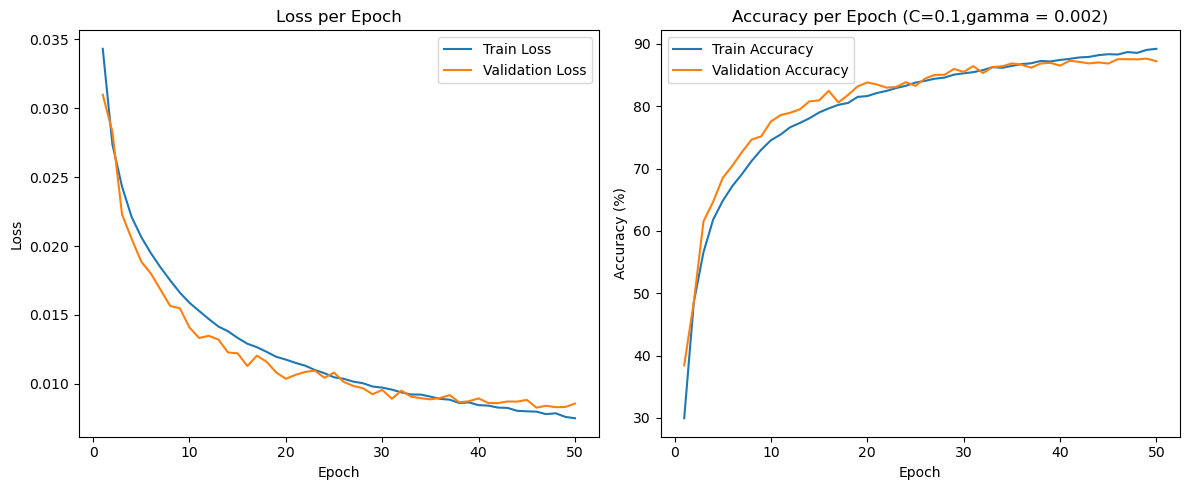

In [10]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=0.1,gamma = 0.002)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1, $\gamma$ = 0.002

In [11]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.002), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_1_002.pth")

Epoch 1/50:
Train Loss: 0.3356, Train Acc: 30.34%
Val Loss: 0.2747, Val Acc: 45.34%
Epoch 2/50:
Train Loss: 0.2612, Train Acc: 48.66%
Val Loss: 0.2314, Val Acc: 56.01%
Epoch 3/50:
Train Loss: 0.2285, Train Acc: 56.89%
Val Loss: 0.2061, Val Acc: 61.36%
Epoch 4/50:
Train Loss: 0.2074, Train Acc: 61.65%
Val Loss: 0.1804, Val Acc: 67.68%
Epoch 5/50:
Train Loss: 0.1903, Train Acc: 65.18%
Val Loss: 0.1727, Val Acc: 68.92%
Epoch 6/50:
Train Loss: 0.1777, Train Acc: 68.04%
Val Loss: 0.1562, Val Acc: 72.41%
Epoch 7/50:
Train Loss: 0.1670, Train Acc: 70.20%
Val Loss: 0.1482, Val Acc: 74.06%
Epoch 8/50:
Train Loss: 0.1590, Train Acc: 71.72%
Val Loss: 0.1356, Val Acc: 76.02%
Epoch 9/50:
Train Loss: 0.1499, Train Acc: 73.71%
Val Loss: 0.1358, Val Acc: 75.93%
Epoch 10/50:
Train Loss: 0.1437, Train Acc: 74.59%
Val Loss: 0.1290, Val Acc: 77.50%
Epoch 11/50:
Train Loss: 0.1376, Train Acc: 75.88%
Val Loss: 0.1237, Val Acc: 78.31%
Epoch 12/50:
Train Loss: 0.1320, Train Acc: 77.14%
Val Loss: 0.1188, Val A

In [12]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0761, Test Accuracy: 87.19%


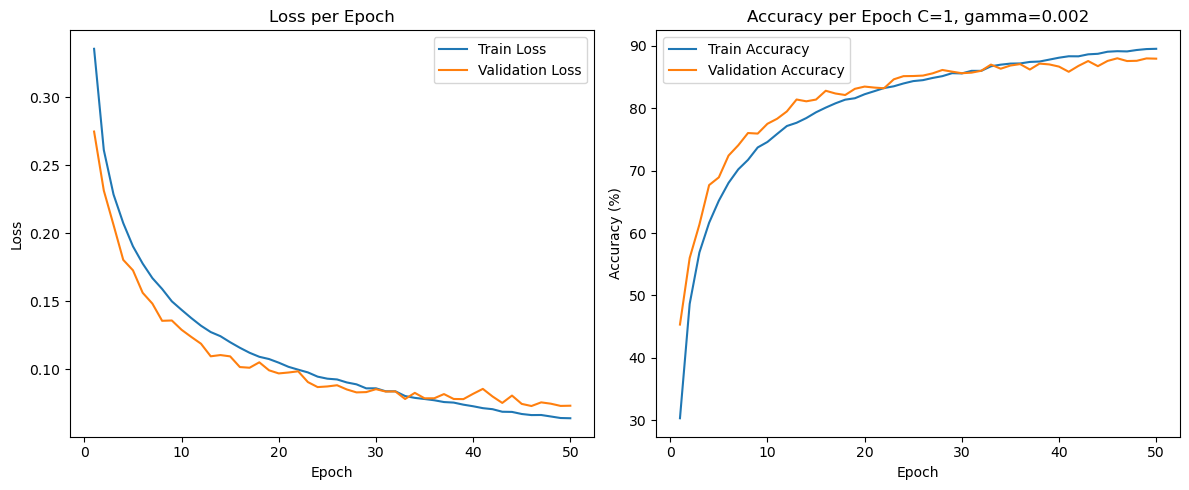

In [13]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch C=1, gamma=0.002")
plt.legend()

plt.tight_layout()
plt.show()

# C=10, $\gamma$ = 0.002

In [14]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.002),  
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_10_002.pth")

Epoch 1/50:
Train Loss: 3.3752, Train Acc: 28.65%
Val Loss: 2.8492, Val Acc: 40.88%
Epoch 2/50:
Train Loss: 2.6119, Train Acc: 47.91%
Val Loss: 2.3656, Val Acc: 54.66%
Epoch 3/50:
Train Loss: 2.2630, Train Acc: 56.68%
Val Loss: 2.1021, Val Acc: 60.89%
Epoch 4/50:
Train Loss: 2.0320, Train Acc: 61.96%
Val Loss: 1.8366, Val Acc: 66.12%
Epoch 5/50:
Train Loss: 1.8783, Train Acc: 65.14%
Val Loss: 1.8124, Val Acc: 66.75%
Epoch 6/50:
Train Loss: 1.7683, Train Acc: 67.55%
Val Loss: 1.5895, Val Acc: 71.08%
Epoch 7/50:
Train Loss: 1.6635, Train Acc: 69.62%
Val Loss: 1.5190, Val Acc: 72.73%
Epoch 8/50:
Train Loss: 1.5722, Train Acc: 71.90%
Val Loss: 1.3384, Val Acc: 76.21%
Epoch 9/50:
Train Loss: 1.4934, Train Acc: 73.08%
Val Loss: 1.3592, Val Acc: 75.74%
Epoch 10/50:
Train Loss: 1.4296, Train Acc: 74.40%
Val Loss: 1.2727, Val Acc: 77.28%
Epoch 11/50:
Train Loss: 1.3720, Train Acc: 75.59%
Val Loss: 1.1588, Val Acc: 79.26%
Epoch 12/50:
Train Loss: 1.3230, Train Acc: 76.55%
Val Loss: 1.2716, Val A

In [15]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7431, Test Accuracy: 87.50%


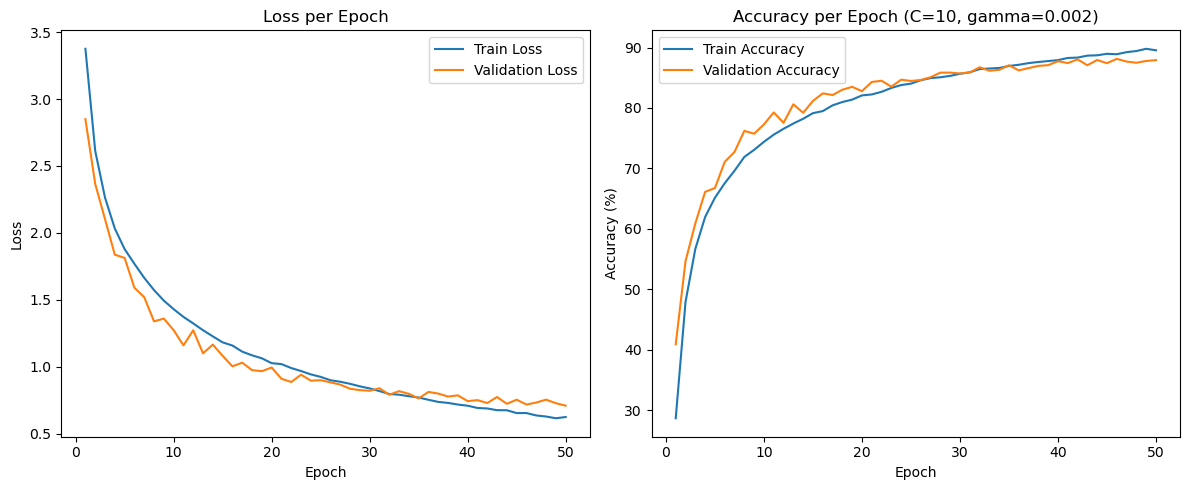

In [16]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=10, gamma=0.002)")
plt.legend()

plt.tight_layout()
plt.show()

# C=100, $\gamma$ = 0.002

In [17]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.002), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_100_002.pth")

Epoch 1/50:
Train Loss: 33.1432, Train Acc: 30.92%
Val Loss: 29.0145, Val Acc: 39.55%
Epoch 2/50:
Train Loss: 25.6374, Train Acc: 49.26%
Val Loss: 22.7744, Val Acc: 56.63%
Epoch 3/50:
Train Loss: 22.1558, Train Acc: 57.51%
Val Loss: 20.3293, Val Acc: 62.26%
Epoch 4/50:
Train Loss: 20.1496, Train Acc: 61.90%
Val Loss: 17.2524, Val Acc: 68.41%
Epoch 5/50:
Train Loss: 18.7583, Train Acc: 65.06%
Val Loss: 16.5610, Val Acc: 69.33%
Epoch 6/50:
Train Loss: 17.5160, Train Acc: 67.81%
Val Loss: 15.7295, Val Acc: 71.18%
Epoch 7/50:
Train Loss: 16.6553, Train Acc: 69.61%
Val Loss: 15.8487, Val Acc: 71.19%
Epoch 8/50:
Train Loss: 15.8992, Train Acc: 71.19%
Val Loss: 14.9251, Val Acc: 73.09%
Epoch 9/50:
Train Loss: 15.2104, Train Acc: 72.43%
Val Loss: 14.0577, Val Acc: 74.19%
Epoch 10/50:
Train Loss: 14.4796, Train Acc: 74.00%
Val Loss: 13.3467, Val Acc: 76.23%
Epoch 11/50:
Train Loss: 13.7935, Train Acc: 75.31%
Val Loss: 12.0106, Val Acc: 78.70%
Epoch 12/50:
Train Loss: 13.3070, Train Acc: 76.44%


In [18]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 7.6381, Test Accuracy: 87.40%


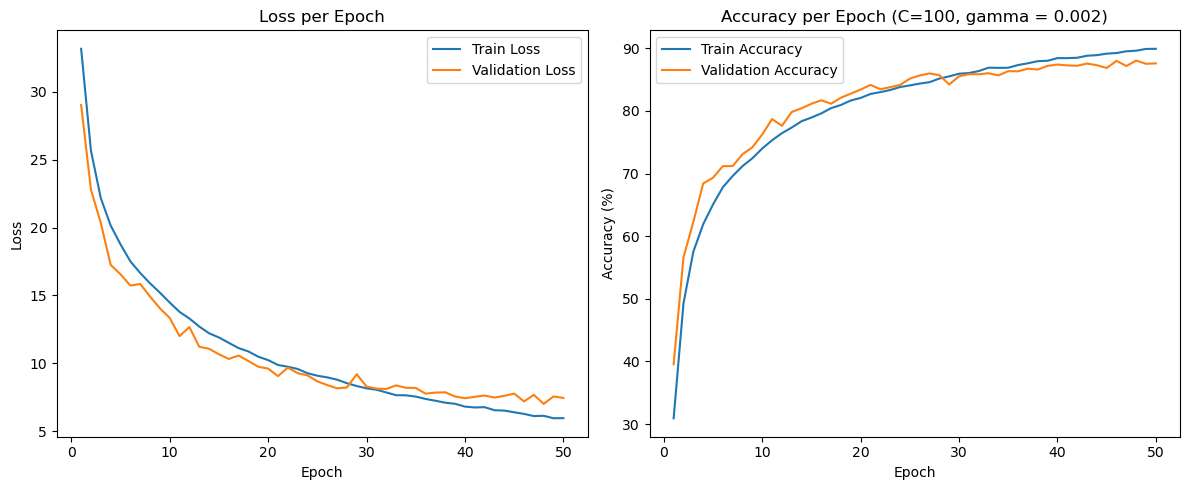

In [19]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=100, gamma = 0.002)")
plt.legend()

plt.tight_layout()
plt.show()

# C=0.1, $\gamma$ = 0.003

In [20]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.003),   
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 0.1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_01_003.pth")

Epoch 1/50:
Train Loss: 0.0348, Train Acc: 28.79%
Val Loss: 0.0296, Val Acc: 42.32%
Epoch 2/50:
Train Loss: 0.0279, Train Acc: 47.56%
Val Loss: 0.0254, Val Acc: 54.43%
Epoch 3/50:
Train Loss: 0.0248, Train Acc: 55.57%
Val Loss: 0.0221, Val Acc: 61.80%
Epoch 4/50:
Train Loss: 0.0225, Train Acc: 61.22%
Val Loss: 0.0209, Val Acc: 64.31%
Epoch 5/50:
Train Loss: 0.0212, Train Acc: 63.97%
Val Loss: 0.0194, Val Acc: 67.93%
Epoch 6/50:
Train Loss: 0.0197, Train Acc: 67.18%
Val Loss: 0.0179, Val Acc: 70.65%
Epoch 7/50:
Train Loss: 0.0187, Train Acc: 69.28%
Val Loss: 0.0175, Val Acc: 71.72%
Epoch 8/50:
Train Loss: 0.0177, Train Acc: 71.14%
Val Loss: 0.0167, Val Acc: 72.93%
Epoch 9/50:
Train Loss: 0.0167, Train Acc: 73.18%
Val Loss: 0.0153, Val Acc: 75.36%
Epoch 10/50:
Train Loss: 0.0159, Train Acc: 74.53%
Val Loss: 0.0157, Val Acc: 74.41%
Epoch 11/50:
Train Loss: 0.0154, Train Acc: 75.36%
Val Loss: 0.0138, Val Acc: 78.36%
Epoch 12/50:
Train Loss: 0.0148, Train Acc: 76.52%
Val Loss: 0.0131, Val A

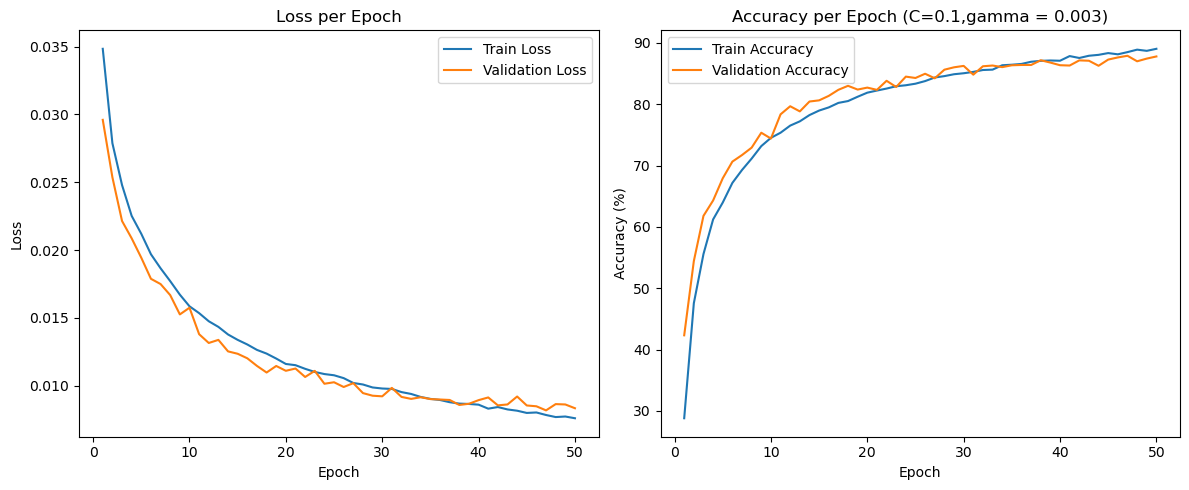

In [21]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=0.1,gamma = 0.003)")
plt.legend()

plt.tight_layout()
plt.show()

# C=1 gamma=0.003

In [22]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.003), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 1)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_1_003.pth")

Epoch 1/50:
Train Loss: 0.3391, Train Acc: 29.06%
Val Loss: 0.3016, Val Acc: 36.97%
Epoch 2/50:
Train Loss: 0.2681, Train Acc: 46.35%
Val Loss: 0.2477, Val Acc: 52.15%
Epoch 3/50:
Train Loss: 0.2322, Train Acc: 55.91%
Val Loss: 0.2101, Val Acc: 61.60%
Epoch 4/50:
Train Loss: 0.2082, Train Acc: 61.45%
Val Loss: 0.1961, Val Acc: 64.10%
Epoch 5/50:
Train Loss: 0.1941, Train Acc: 64.68%
Val Loss: 0.1740, Val Acc: 68.72%
Epoch 6/50:
Train Loss: 0.1817, Train Acc: 67.06%
Val Loss: 0.1620, Val Acc: 71.39%
Epoch 7/50:
Train Loss: 0.1689, Train Acc: 69.64%
Val Loss: 0.1577, Val Acc: 72.19%
Epoch 8/50:
Train Loss: 0.1598, Train Acc: 71.79%
Val Loss: 0.1469, Val Acc: 74.08%
Epoch 9/50:
Train Loss: 0.1509, Train Acc: 73.44%
Val Loss: 0.1405, Val Acc: 75.64%
Epoch 10/50:
Train Loss: 0.1453, Train Acc: 74.45%
Val Loss: 0.1265, Val Acc: 77.90%
Epoch 11/50:
Train Loss: 0.1405, Train Acc: 75.39%
Val Loss: 0.1387, Val Acc: 75.92%
Epoch 12/50:
Train Loss: 0.1348, Train Acc: 76.57%
Val Loss: 0.1190, Val A

In [23]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.0744, Test Accuracy: 87.91%


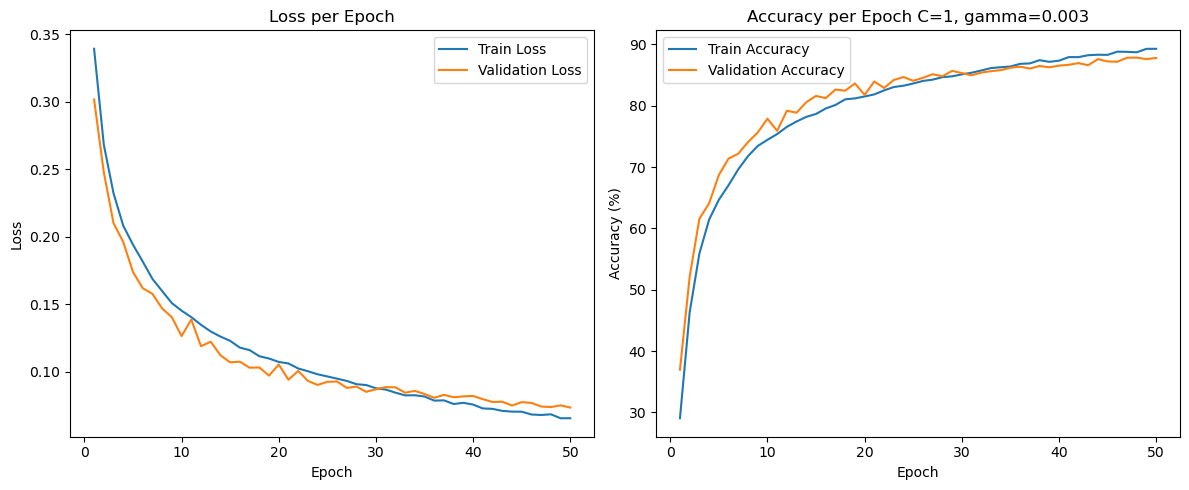

In [24]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch C=1, gamma=0.003")
plt.legend()

plt.tight_layout()
plt.show()

# C=10, $\gamma$ = 0.003

In [25]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.003),  
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 10)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_10_003.pth")

Epoch 1/50:
Train Loss: 3.4143, Train Acc: 28.34%
Val Loss: 2.7802, Val Acc: 43.52%
Epoch 2/50:
Train Loss: 2.6237, Train Acc: 47.37%
Val Loss: 2.3009, Val Acc: 55.90%
Epoch 3/50:
Train Loss: 2.2656, Train Acc: 56.59%
Val Loss: 1.9797, Val Acc: 63.21%
Epoch 4/50:
Train Loss: 2.0399, Train Acc: 61.97%
Val Loss: 1.8542, Val Acc: 65.98%
Epoch 5/50:
Train Loss: 1.8663, Train Acc: 65.53%
Val Loss: 1.8661, Val Acc: 65.51%
Epoch 6/50:
Train Loss: 1.7435, Train Acc: 68.11%
Val Loss: 1.6678, Val Acc: 69.57%
Epoch 7/50:
Train Loss: 1.6279, Train Acc: 70.17%
Val Loss: 1.4663, Val Acc: 73.71%
Epoch 8/50:
Train Loss: 1.5361, Train Acc: 72.12%
Val Loss: 1.3499, Val Acc: 75.89%
Epoch 9/50:
Train Loss: 1.4571, Train Acc: 73.75%
Val Loss: 1.3257, Val Acc: 76.08%
Epoch 10/50:
Train Loss: 1.3966, Train Acc: 75.00%
Val Loss: 1.2273, Val Acc: 78.51%
Epoch 11/50:
Train Loss: 1.3423, Train Acc: 76.04%
Val Loss: 1.1743, Val Acc: 79.44%
Epoch 12/50:
Train Loss: 1.2718, Train Acc: 77.55%
Val Loss: 1.1811, Val A

In [26]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.7439, Test Accuracy: 87.53%


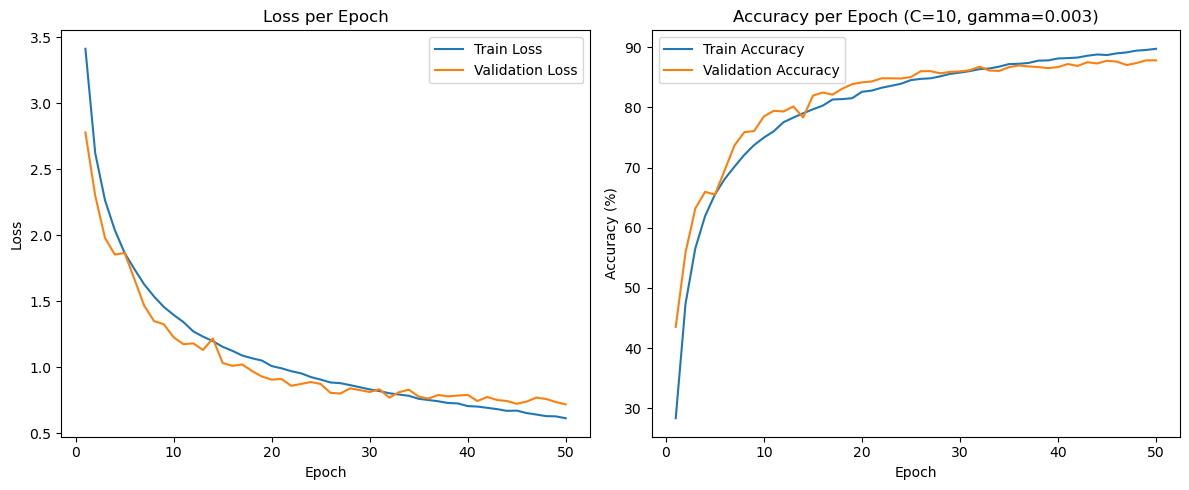

In [27]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=10, gamma=0.003)")
plt.legend()

plt.tight_layout()
plt.show()

# C=100, $\gamma$ = 0.003

In [28]:
# Set model
resnet18_from_scratch = ResNet18(num_classes=10)  # Initialize ResNet18 with 10 output classes
model = resnet18_from_scratch
# new layer with RFF
model.fc = nn.Sequential(
    RandomFourierFeatures(input_dim=embedding_dim, D=rff_dim, gamma=0.003), 
    nn.Linear(rff_dim, 10)  
)
model = model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters())  # Adam optimizer for model parameters

# Training function
def train(model, loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
        optimizer.zero_grad()  # Zero the gradients from the previous step
        
        # Get model outputs (logits)
        outputs = model(inputs)

        # Get weights of the final layer
        readout_weights = model.fc[-1].weight


        # Calculate the square hinge loss with L2 regularization
        loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters
        

        total_loss += loss.item()  # Accumulate loss
        _, predicted = outputs.max(1)  # Get the predicted class
        total += targets.size(0)  # Total number of samples
        correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Validation function
def validate(model, loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation during validation
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the device
            outputs = model(inputs)

            # Get weights of the final layer
            readout_weights = model.fc[-1].weight


            # Calculate the square hinge loss with L2 regularization
            loss = square_hinge_loss(outputs, targets, readout_weights, C = 100)

            total_loss += loss.item()  # Accumulate loss
            _, predicted = outputs.max(1)  # Get the predicted class
            total += targets.size(0)  # Total number of samples
            correct += predicted.eq(targets).sum().item()  # Count correct predictions

    # Return average loss and accuracy
    return total_loss / len(loader), 100. * correct / total

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader,optimizer)
    val_loss, val_acc = validate(model, val_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

torch.save(model.state_dict(), "svm_rff_020_100_003.pth")

Epoch 1/50:
Train Loss: 33.9389, Train Acc: 28.57%
Val Loss: 27.7258, Val Acc: 45.97%
Epoch 2/50:
Train Loss: 26.0841, Train Acc: 48.51%
Val Loss: 22.8376, Val Acc: 56.43%
Epoch 3/50:
Train Loss: 22.5239, Train Acc: 57.06%
Val Loss: 23.3464, Val Acc: 56.35%
Epoch 4/50:
Train Loss: 20.3429, Train Acc: 61.75%
Val Loss: 19.0683, Val Acc: 64.34%
Epoch 5/50:
Train Loss: 18.6661, Train Acc: 65.43%
Val Loss: 17.0633, Val Acc: 68.93%
Epoch 6/50:
Train Loss: 17.2954, Train Acc: 68.25%
Val Loss: 16.4415, Val Acc: 69.58%
Epoch 7/50:
Train Loss: 16.0536, Train Acc: 70.84%
Val Loss: 13.9718, Val Acc: 74.96%
Epoch 8/50:
Train Loss: 15.0831, Train Acc: 72.79%
Val Loss: 13.5831, Val Acc: 75.37%
Epoch 9/50:
Train Loss: 14.3273, Train Acc: 74.21%
Val Loss: 12.6848, Val Acc: 77.09%
Epoch 10/50:
Train Loss: 13.6570, Train Acc: 75.47%
Val Loss: 11.7505, Val Acc: 79.14%
Epoch 11/50:
Train Loss: 13.0694, Train Acc: 76.62%
Val Loss: 12.0971, Val Acc: 78.73%
Epoch 12/50:
Train Loss: 12.6484, Train Acc: 77.55%


In [29]:
# Results on Test Set
test_loss, test_acc = validate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 7.7665, Test Accuracy: 87.22%


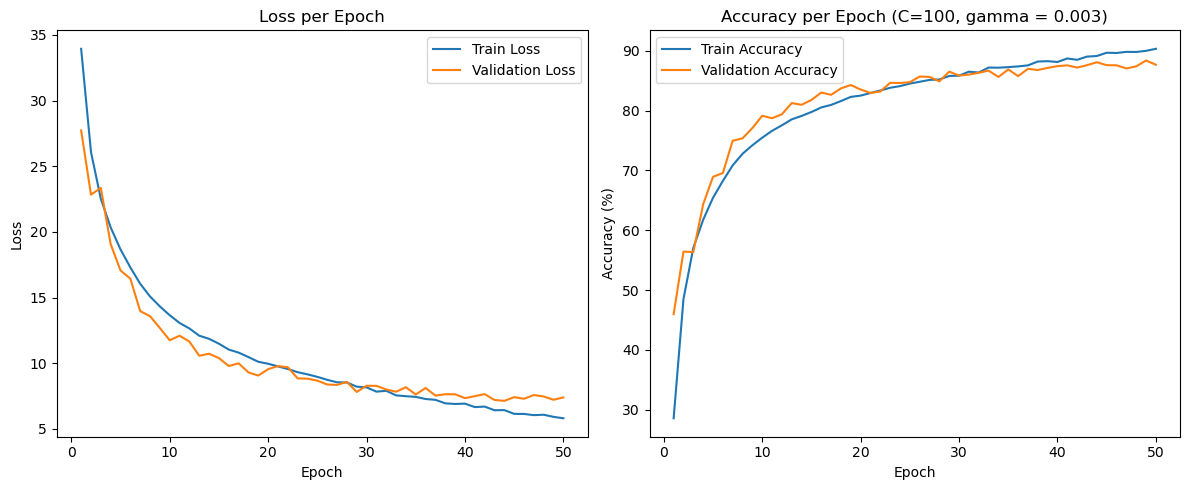

In [30]:
# Metrics plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch (C=100, gamma = 0.003)")
plt.legend()

plt.tight_layout()
plt.show()